In [1]:
%load_ext autoreload
%autoreload 2
    
from d3pm_sc.d3pm import D3PM
from d3pm_sc.unet import UNet

import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST, CIFAR10
from torchvision.utils import make_grid
from tqdm import tqdm

from matplotlib import pyplot as plt

In [2]:
N = 4  # number of classes for discretized state per pixel
n_T = 1000
n_channel = 3
gamma = 1/N

d3pm = D3PM(UNet(n_channel, N, n_T, True),
            n_T, num_classes=N, hybrid_loss_coeff=0.0, gamma=gamma).cuda()
print(f"Total Param Count: {sum([p.numel() for p in d3pm.x0_model.parameters()])}")
dataset = CIFAR10(
    "./data",
    train=True,
    download=True,
    transform=transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
)
train_size = int(len(dataset) * 0.9)
dataset, test_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=16)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=16)


Total Param Count: 63314240
Files already downloaded and verified


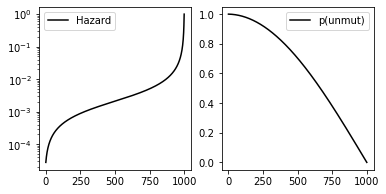

In [3]:
fig, ax = plt.subplots(1, 2, figsize=[6, 3])
ax[0].semilogy(d3pm.beta_t, label="Hazard", color='black')
ax[0].legend()

steps = torch.arange(d3pm.n_T + 1, dtype=torch.float64) / d3pm.n_T
alpha_bar = torch.cos((steps + 0.008) / 1.008 * torch.pi / 2)
ax[1].plot(alpha_bar, label="p(unmut)", color='black')
ax[1].legend()

In [ ]:
optim = torch.optim.AdamW(d3pm.x0_model.parameters(), lr=1e-3)
d3pm.train()

n_epoch = 14
device = "cuda"

global_step = 0
for i in range(n_epoch):

    pbar = tqdm(dataloader)
    loss_ema = None
    for x, cond in pbar:
        optim.zero_grad()
        x = x.to(device)
        cond = cond.to(device)
        x = (x * (N - 1)).round().long().clamp(0, N - 1)
        
        loss, info = d3pm(x, cond)

        loss.backward()
        norm = torch.nn.utils.clip_grad_norm_(d3pm.x0_model.parameters(), 0.1)

        # log
        with torch.no_grad():
            param_norm = sum([torch.norm(p) for p in d3pm.x0_model.parameters()])

        if loss_ema is None:
            loss_ema = loss.item()
        else:
            loss_ema = 0.99 * loss_ema + 0.01 * loss.item()
        pbar.set_description(
            f"loss: {loss_ema:.4f}, norm: {norm:.4f}, param_norm: {param_norm:.4f}, vb_loss: {info['vb_loss']:.4f}, ce_loss: {info['ce_loss']:.4f}"
        )
        optim.step()

        global_step += 1
        if global_step % 300 == 1:
            d3pm.eval()
            with torch.no_grad():
                # save images
                cond = torch.arange(0, 4).cuda() % 10
                init_noise = torch.randint(0, N, (4,)+x.shape[1:]).cuda()

                images = d3pm.sample_with_image_sequence(
                    init_noise, cond, stride=40
                )
                # image sequences to gif
                gif = []
                for image in images:
                    x_as_image = make_grid(image.float() / (N - 1), nrow=2)
                    img = x_as_image.permute(1, 2, 0).cpu().numpy()
                    img = (img * 255).astype(np.uint8)
                    gif.append(Image.fromarray(img))

                gif[0].save(
                    f"contents/sample_{global_step}.gif",
                    save_all=True,
                    append_images=gif[1:],
                    duration=100,
                    loop=0,
                )

                last_img = gif[-1]
                last_img.save(f"contents/sample_{global_step}_last.png")

                val_loss = []
                for x, cond in test_dataloader:
                    optim.zero_grad()
                    x = x.to(device)
                    cond = cond.to(device)
                    x = (x * (N - 1)).round().long().clamp(0, N - 1)
                    
                    loss, info = d3pm(x, cond)
                    val_loss.append(info['vb_loss'])
                bpd = np.mean(val_loss).round(4)
                print("val bits per dim:", bpd, ", preplexity:", np.exp(bpd).round(4))

            d3pm.train()

100%|████████████████████████████████████████| 999/999 [00:09<00:00, 110.90it/s]
loss: 1.5895, norm: 1.5373, param_norm: 1237.0111, vb_loss: 1.3443, ce_loss: 1.3

val bits per dim: 1.39 , preplexity: 4.014850052994202


100%|████████████████████████████████████████| 999/999 [00:09<00:00, 101.18it/s]
loss: 1.2002, norm: 0.1656, param_norm: 1292.8795, vb_loss: 1.0543, ce_loss: 1.1

val bits per dim: 1.18 , preplexity: 3.2543742028896707


100%|█████████████████████████████████████████| 999/999 [00:10<00:00, 98.72it/s]
loss: 1.1766, norm: 0.1134, param_norm: 1298.4401, vb_loss: 1.2711, ce_loss: 1.1

val bits per dim: 1.17 , preplexity: 3.2219926385284996


loss: 1.1818, norm: 0.2228, param_norm: 1301.6067, vb_loss: 1.2120, ce_loss: 1.1
loss: 1.1398, norm: 0.1142, param_norm: 1301.9215, vb_loss: 1.1771, ce_loss: 1.2

In [ ]:
torch.save(d3pm.state_dict(), 'models/d3pm_cifar10_aug10')

In [66]:
import gc
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()

n_samples = 200

cond = torch.zeros(n_samples).cuda().to(torch.int64)
init_noise = torch.randint(0, N, (n_samples, n_channel, 32, 32)).cuda()

images = d3pm.sample_with_image_sequence(
    init_noise, cond, stride=1
)
images = torch.cat([im[None, ...] for im in images], 0)
images = torch.cat([init_noise[None, ...], images], 0)
diffs = (images[1:] != images[:-1]).reshape(n_T-1, n_samples, -1)

(array(14), torch.Size([200, 3, 32, 32])): : 999it [00:43, 22.93it/s]  


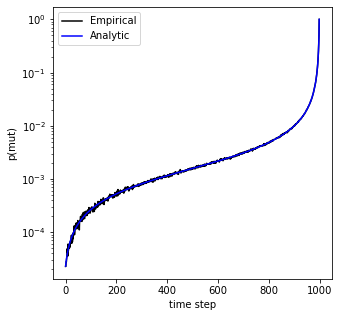

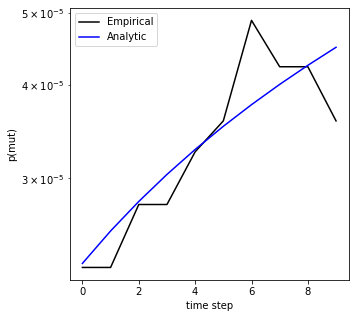

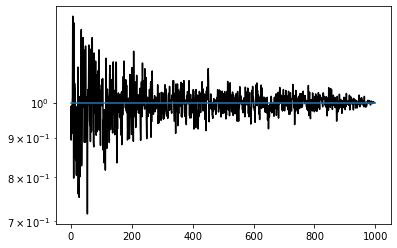

In [67]:
r1 = diffs.cpu().numpy().mean(-1).mean(-1)[::-1]
r2 = d3pm.beta_t[1:].cpu().numpy()
plt.figure(figsize=[5, 5])
plt.semilogy(r1, label="Empirical", color='black')
plt.semilogy(r2, label="Analytic", color='blue')
plt.xlabel("time step")
plt.ylabel("p(mut)")
plt.legend()
# plt.savefig("figures/schedule_comparison.png")

plt.figure(figsize=[5, 5])
plt.semilogy(r1[:10], label="Empirical", color='black')
plt.semilogy(r2[:10], label="Analytic", color='blue')
plt.xlabel("time step")
plt.ylabel("p(mut)")
plt.legend()
# plt.savefig("figures/schedule_comparison_zoom.png")

plt.figure()
plt.semilogy(r1/r2, color='black')
plt.plot([0, 1000], np.ones(2))